## Supervised Learning
## Project: Finding Donors for *CharityML*

## Introduction

In this project, we will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. The goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, we will compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`. 

In [2]:
# Total number of records
n_records = len(data)

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data['income'] == ">50K"])

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income'] == "<=50K"])

# Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k/n_records) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

The code cell below plots a histogram of these two features.

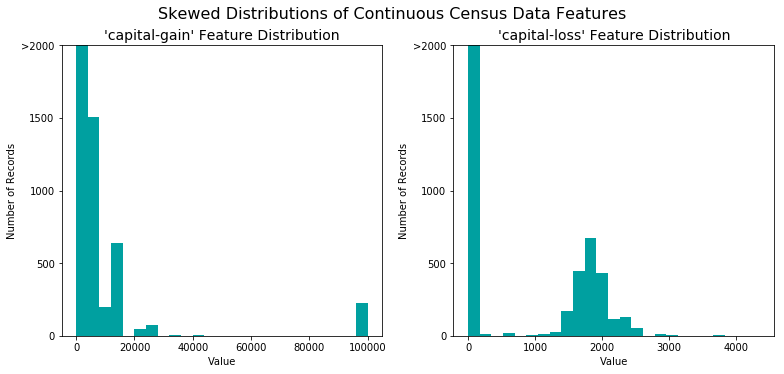

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

The code cell below performs a transformation on the data and visualize the results.

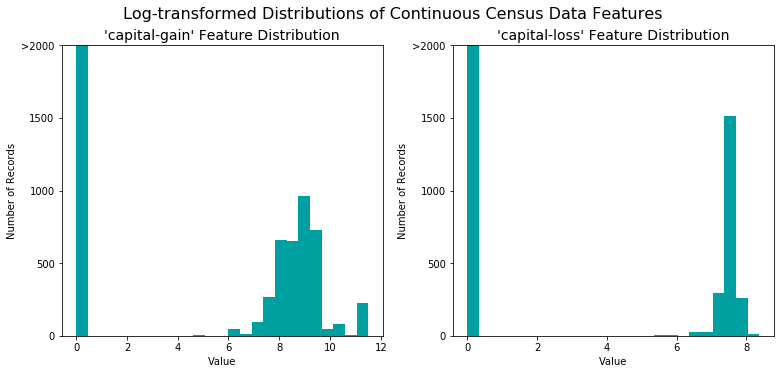

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Data Preprocessing

 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda string: 0 if string == "<=50K" else 1)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of our choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

###  - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? 

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like.

** Note: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [8]:
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data  encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
accuracy = (TP+TN)/(TP+FP+TN+FN)
recall = TP/(TP+FN)
precision = TP/(TP+FP)
# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + 0.5**2)*(precision*recall)/((0.5**2 * precision)+recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that we may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Model Application

The models we will use for testing are the followings: AdaBoost, Random Forest, and Gradient Boosting. Based on the census data we will use in this project, we need a model which can predict with high precision (this will reflect on the f-score : beta = 0.5 when we measure the model performance), fast, can handle medium to large dataset (we have 45,222 records) and more than 100 features (after one-hot encoding categorical features), and which does not have strong assumption about the relatinship/shape of the data. According to above, models based on Decison Tree should be more appropriate for this problem. Please see the references below for model selection considerations/suggestions. Below are reasons why we didn't select certain models:
    - Gaussian Naive Bayes (GaussianNB) - has strong feature independence assumptions. Sometimes does not perform well
        when the assumption does not hold. Most used in text processing, like spam detector type of application.
    
    - K-Nearest Neighbors (KNeighbors): Need to determine a good value for "K". Not so easy when using this dataset. KNN
        performs better in a low dimensional (in terms of number of features) space.
    
    - Logistic Regression: works better if features and target has linear relationship. For our dataset, this is unknown.
    
    - Support Vector Machines (SVM): we don't know if the (features, target) has linear or polynomial relationship, so we may
        need to use sklearn SVC with default setting (which is 'rbf' kernel). Default SVC are complex and sometimes slow to
        train. (see discussion in the last link below).

A) AdaBoost:
   1.1) Real world application: Customer relationship prediction.
   https://gallery.azure.ai/Experiment/Binary-Classification-Customer-relationship-prediction-1. The data used for this
   experiment is from KDD Cup 2009. The dataset has 50000 rows and 230 feature columns. The task is to predict churn, appetency
   and up-selling using these features. Please refer to the KDD Cup 2009 website for further details about the data and the
   task. The characteristic of this dataset: has medium size (1k < data < 100k) data, more than 100 features, relationship among
   features and between features and target are unknow. AdaBoost is suitable for this type of application.
   1.2) Strength: high accuracy and reasonably fast. No prior knowledge needed about weak learner. 
   1.3) Weakness: it may take longer to train and predict if data is really too large. It may take longer than Random Forest,
   where each predictor can predict independantly without learning from previous predictor. Weak classifiers too complex may 
   leads to overfitting. 
   1.4) For this problem, we need a model which can predict with "precision" and fast on data with medium size/more than 100
   features, and can handle features/target with unknown relationship, AdaBoost is a good candidate for this problem. Please see
   first 2 links below for suggestions for model selections.
   
B) Random Forest
   2.1) Real world application: a model that can predict whether a customer will churn.
   https://gallery.azure.ai/Experiment/Telco-Customer-Churn-5. The link gives a real example where this model can be used. The
   input data consists of 50,000 rows. Each row has 230 columns. The first 190 columns contain numerical data and the remaining
   40 columns contain categorical data. Basically: dataset has medium size (1k < data < 100k), more than 100 features, 
   relationship among features and between features and target are unknow, can handle both numerical data and categorical data
   well. Random Forest is suitable for applications with above characteristics.   
   2.2) Strength: high accuracy, reasonably fast, good for parallel or distributed computing. Deal really well with uneven data
   sets that have missing variables.
   2.3) Weakness: Not easy to understand if predictions need to be understand and interpret. 
   2.4) For this problem, we need a model which can predict with "precision" and fast on data with medium size/more than 100
   features, and can handle features/target with unknown relationship, Random Forest is a good candidate for this problem.
   Please see first 2 links below for suggestions for model selections.
   
C) Gradient Boost:
   3.1) Real world application: Customer relationship prediction.
   https://gallery.azure.ai/Experiment/Binary-Classification-Customer-relationship-prediction-1. The data used for this
   experiment is from KDD Cup 2009. The dataset has 50000 rows and 230 feature columns. The task is to predict churn, appetency
   and up-selling using these features. Please refer to the KDD Cup 2009 website for further details about the data and the
   task. The characteristic of this dataset: has medium size (1k < data < 100k), more than 100 features, relationship among
   features and between features and target are unknow. Gradient Boost is suitable for applications with above characteristics.
   3.2) Strength: high accuracy, most of time perform even better than Random Forest.
   3.3) Weakness: it may take longer to train compared to Random Forest, where each predictor can predict independantly without
   learning from previous predictor. More parameters need to tune. May not perform that well when dataset is too large. 
   3.4) For this problem, we need a model which can predict with "precision" and fast on data with medium size/more than 100
   features, and can handle features/target with unknown relationship,  Gradient Boost is a good candidate for this problem. 
   Please see first 2 links below for suggestions for model selections. 
   
References: 
https://www.datasciencecentral.com/profiles/blogs/which-machine-learning-algorithm-should-i-use
https://docs.microsoft.com/en-us/azure/machine-learning/studio/algorithm-cheat-sheet
https://docs.microsoft.com/en-us/azure/machine-learning/studio/algorithm-choice
https://www.quora.com/What-is-better-k-nearest-neighbors-algorithm-k-NN-or-Support-Vector-Machine-SVM-classifier-Which-algorithm-is-mostly-used-practically-Which-algorithm-guarantees-reliable-detection-in-unpredictable-situations
http://scikit-learn.org/stable/tutorial/machine_learning_map/
https://stackoverflow.com/questions/40077432/scikit-learn-svm-svc-is-extremely-slow/40077679
https://www.hackingnote.com/en/machine-learning/algorithms-pros-and-cons/
http://www-math.mit.edu/~rothvoss/18.304.3PM/Presentations/1-Eric-Boosting304FinalRpdf.pdf

### Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model chosen, it's important that we create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. The implementation here will be used in the following section.
In the code block below, we will implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Set the `beta` parameter!

In [9]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta = 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, we will implement the following:
- Import the three supervised learning models we discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model used, if provided.
  - **Note:** We will use the default settings for each model — we will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


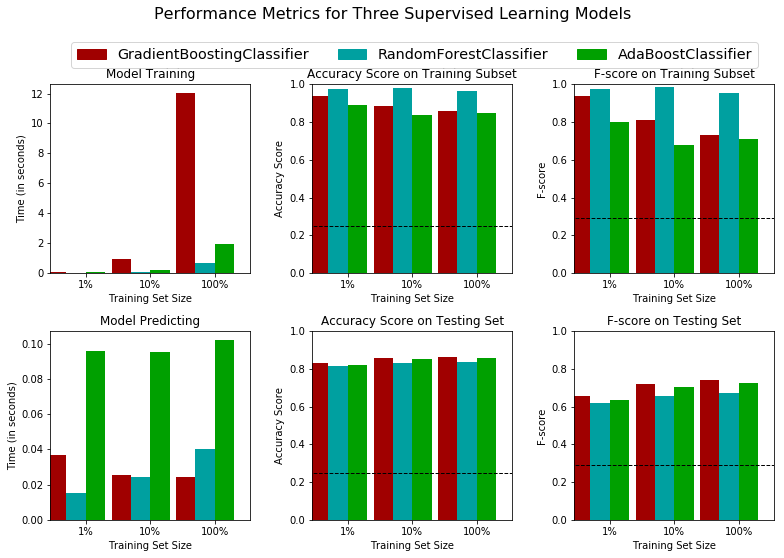

In [10]:
# Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

# Initialize the three models
clf_A = GradientBoostingClassifier()
clf_B = RandomForestClassifier()
clf_C = AdaBoostClassifier()

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# Samples_100 is the entire training set i.e. len(y_train)
# Samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# Samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(0.1*samples_100)
samples_1 = int(0.01*samples_100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, we will choose from the three supervised learning models the *best* model to use on the student data. We will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Choosing the Best Model

**Conclusion:**
Based on the above evaluation, I believe the most appropriate model is Gradient Boosting.
1. It has the highest F score - (F score on the testing when 100% of the training data is used).
2. Although training time is longer, but the predicting time is fine.
3. The algorithm is quit suitable for this kind of application - since we need high precision, ensemble method using Boosting
   make prediction by learning the mistake from previous predictors. It should has higher precision.

### Describing the Model in Layman's Terms

**Conclusion: ** 
The model I choosed is Gradient Boosting. Gradient boosting is based on Decision Tree Model. A Decision Tree is built top-down from a root node and involves partitioning the data into subsets that contain instances with similar values (homogenous). Decison Tree has the following advantages: easy to interpret and make for straightforward visualizations; can handle both numerical and categorical data; perform well on large datasets; are extremely fast. However, Decision Tree also has some disadvantages including: building Decision Trees require algorithms capable of determining an optimal choice at each node;
Decision Trees are prone to overfitting, especially when a tree is particularly deep. A common way to fix the issues of a Decision Tree is using ensemble method, like Boosting, for example Gradient Boosting. Gradient Boosting can not only fix the issues of the Decision Tree, it may also enhance the accuracy of a Decision Tree by using multiple weak predictor to form a stronger predictor.

Gradient Boosting works like below (with some explanations in math):
Given a training data {xi,yi}(i=1 to N) , we need to find a model F(x) that map x to y . We will measure the mapping effectiveness by choosing a loss function L(y,F(x)) and then minimize it. The model F(x) is constructed in the form: 
F(x)=F0(x)+ sum(beta_m x hm(x)). This is called boosting where: F0(x) is a initial guess, the first starting point of the model.
hm(x) is called “weak learner” or “base learner”. We start the process by choosing F0(x), then measure the error between target y and prediction F0(x) : y−F0(x). Next, we try to find a new function h0(x) so that: F0(x)+beta_0 x h0(x)=y. The role of h0 is to reduce the error of predictive model F(x). This step is proceeded recursively, we can add up another h1,…,hm until the best F∗ is found. Each new hm will try to correct errors made by previous hm−1 so that: Fm(x)+beta_m x hm(x)=y. One way to obtain that is to use “steepest descent” to find the right direction for hm to follow: take (minus of) the partial derivates of loss function (between target and the prediction made by current model) wrt the  predictor function F(x) since we want a predictor that minimizes the total loss. So in each step (1 to m), compute residuals, fit base learner, h(m)(x) to residuals.The intuition is that at each iteration, hm will continue to explore the path that its predecessor hm−1 has already followed and try to reach closer to the local minimum of loss function by following the negative gradient direction using the “steepest descent”. The difference between Gradient Boosting and Gradient Descent in each step is: Gradient Boosting adds a new function to the model that moves along the negative gradient direction. Whereas Gradient Descent updates its parameter along the negative gradient direction. Both also try to reach a local minimum of the loss function.

This is how the final model chosen (Gradient Boosting) is supposed to work (in layman's terms):
1. Initialize the model with a constant value
2. Subsequent models predict the error residual of the previous predictions - repeat this step from 1 to m times, until
   best model is found:
   - Find a new weak learner (predictor), h(m) which will try to correct errors made by previous predictor h(m−1) - h(m)
     will try to reach closer to the local minimum of loss function (error between target and prediction made by new model) 
     by following the negative gradient direction using the “steepest descent”. 
   - Compute residuals r(m), fit base learner, h(m)(x) to residuals
3. The final model is constructed by the sum of 
    a) The initial guess, the first starting point of the model. (from 1). 
    b) a step magnitude multiplier, times the “weak learner” (“base learner”) in each iteraction described in 2.

Some of my explanation come from the following articles: 
    http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/
    https://www.quora.com/What-is-an-intuitive-explanation-of-Gradient-Boosting
    https://towardsdatascience.com/decision-trees-and-random-forests-df0c3123f991

### Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. In the code cell below, we will implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters we wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

In [11]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = GradientBoostingClassifier(random_state=1)

# Create the parameters list you wish to tune, using a dictionary if needed.
# Parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'n_estimators': [100, 300, 500]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8718
Final F-score on the testing data: 0.7545


### Final Model Evaluation

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |    0.8630         |     0.8718      |
| F-score        |    0.7395         |     0.7545      |


**Conclusion: **
1. See "Results".
2. These scores are better than the unoptimized model.
3. Those results are much better than the naive predictor benchmarks found eariler.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

We will choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Feature Relevance Observation

**Before looking at the Feature Importance attribute, we think the following are top 5 most important features to predict the result:**
1. age 2. education-num 3. hours-per-week 4.marital-status 5. capital-gain.

Age determines the salary range - the older a person is, the higher the salary is.
Education-num also has impact on the salary range, but not as big impact as age.
Hours-per-week determines full-time/part time, also make difference in income.
Marital-status makes difference on income - when filing tax, and if one party pay the animony to the other party.
Capital-gain determines if person has more income of not.


### Extracting Feature Importance

In the code cell below, we will implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

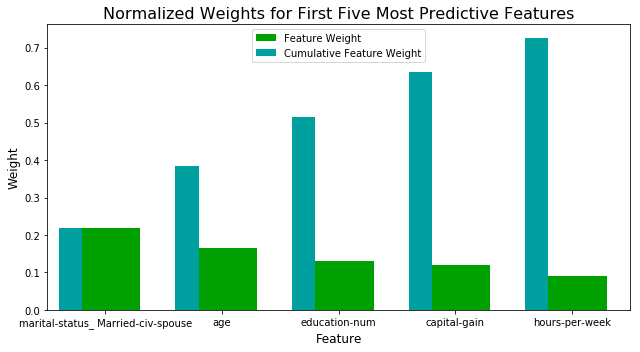

In [12]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.tree import DecisionTreeClassifier 

# Train the supervised model on the training set using .fit(X_train, y_train)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Extracting Feature Importance

**Conclusion:** 
1. The five features extracted from feature importance is pretty much the same as the 5 features I listed eariler, except
   the order is different.
2. This visualization confirms that all the factors have direct impact on the income, while the importance among them 
   are not very big. So the order might be a little bit different.

### Feature Selection
From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model found earlier, and train it on the same training set *with only the top five important features*. 

In [13]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8718
F-score on testing data: 0.7545

Final Model trained on reduced data
------
Accuracy on testing data: 0.8498
F-score on testing data: 0.7035


### Effects of Feature Selection

**Conclusion:**
1. Comparison of the F-score and accuracy between (final model trained on reduced feature sets) and (final model trained on full feature sets): the difference are not too big. F-score/accuracy are still good.
2. If training time was a factor, I would consider use the reduced data as my training set, since Boosting type of ensemble method sometimes take time to train. In my case, Gradient Boosting takes much shorter time to train while performance did not reduce too much.